## Treci domaci zadatak - Metod nosecih vektora

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qpsolvers import solve_qp
from collections import defaultdict

In [2]:
def stand(x_train):
    sr_vr = x_train.mean()
    std = x_train.std(ddof=0)

    return (x_train - sr_vr) / std

In [3]:
class SVM_primal:
    def __init__(self, C):
        self.C = C
    
    def fit(self, X, y):
        m = X.shape[0]
        n = X.shape[1]
        
        P = np.hstack([np.eye(n), np.zeros((n, m + 1))])
        P = np.vstack([P, np.zeros((m + 1, m + n + 1))])
        
        q = self.C * np.hstack([np.zeros(n + 1), np.ones(m)])
        
        h = np.hstack([-np.ones(m), np.zeros(m)]) 
        
        G1 = -y[:, None] * X
        G1 = np.hstack([G1, -y.reshape(-1, 1), -np.eye(m)])
        
        G2 = np.hstack([np.zeros((m, n + 1)), -np.eye(m)])
        
        G = np.vstack([G1, G2])
        
        x = solve_qp(P, q, G, h, solver="osqp")

        self.coef_ = x[:n]
        self.intercept_ = x[n]
        self.hinge_loss_ = x[n + 1:]
        
        tol = 1e-4
        ind_sv = np.where(y * (X @ self.coef_ + self.intercept_) <= 1 + tol)[0]
        self.support_vectors_ = X[ind_sv, :]
        self.support_vectors_hinge_loss_ = self.hinge_loss_[ind_sv]
        
        return self
        
    def predict(self, x):
        return np.sign(x @ self.coef_ + self.intercept_)

In [4]:
class SVM_dual:
    def __init__(self, C, sigma):
        self.C = C
        self.sigma = sigma
        
    def kernel(self, x1, x2):
        diff = x1 - x2
        return np.exp(-(diff @ diff) / (2 * self.sigma**2))

    def fit(self, X, y):
        m = X.shape[0]
        n = X.shape[1]
        
        P = np.empty((m, m))
        for i in range(m):
            for j in range(m):
                P[i][j] = y[i] * y[j] * self.kernel(X[i, :], X[j, :])
                
        q = -np.ones(m)
        A = y.reshape(1, -1)
        b = np.array([0])
        
        lb = np.zeros(m)
        ub = self.C * np.ones(m)
        
        self.alpha = solve_qp(P=P, q=q, A=A, b=b, lb=lb, ub=ub, solver="osqp")
        
        tol = 1e-4
        
        ind_sv = np.where(self.alpha > tol)[0]
        self.support_vectors_ = X[ind_sv, :]
        self.alpha_sv_ = self.alpha[ind_sv]
        self.y_sv_ = y[ind_sv]
        
        ind_b = np.where((self.alpha > tol) & (self.alpha < self.C - tol))[0]
        if len(ind_b) == 0:
            ind_b = ind_sv

        bs = []
        for idx in ind_b:
            s = 0.0
            for j in range(m):
                s += self.alpha[j] * y[j] * self.kernel(X[j], X[idx])
            bs.append(y[idx] - s)
        self.intercept_ = float(np.mean(bs))
        
        self.margins_ = self.y_sv_ * (self.fcn(self.support_vectors_) + self.intercept_)
        self.support_vectors_hinge_loss_ = np.maximum(0, 1 - self.margins_)
        
        return self
    
    def fcn(self, x):
        sums = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            s = 0
            for j in range(self.support_vectors_.shape[0]):
                s += self.alpha_sv_[j] * self.y_sv_[j] * self.kernel(self.support_vectors_[j, :], x[i, :])
            sums[i] = s
            
        return sums

    def predict(self, x):
        return np.sign(self.fcn(x) + self.intercept_)

In [5]:
data = pd.read_csv('svmData.csv', header=None)
X = data.iloc[:,:-1]
y = data.iloc[:, -1]


X_std = stand(X)

X_std = np.asarray(X_std)
X = np.asarray(X)
y = np.asarray(y)

In [6]:
CC = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]) # za C = 1e4 -> ne moze da resi
n_train = X_std.shape[0]

K = 5
train_scores = np.empty((len(CC), K))
val_scores = np.empty((len(CC), K))

for k in range(K):
    start = int(k * n_train / K)
    end = int((k + 1) * n_train / K)
    
    x_train_k = np.vstack([X_std[:start], X_std[end:]])
    y_train_k = np.hstack([y[:start], y[end:]])
    
    x_val_k = X_std[start:end]
    y_val_k = y[start:end]
    
    for i in range(len(CC)):
        C = CC[i]
        svm = SVM_primal(C).fit(x_train_k, y_train_k)
        
        train_scores[i][k] = np.mean(np.maximum(0, 1 - y_train_k * (x_train_k @ svm.coef_ + svm.intercept_)))
        val_scores[i][k] = np.mean(np.maximum(0, 1 - y_val_k * (x_val_k @ svm.coef_ + svm.intercept_)))
        
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

/Users/vuk/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'P' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(
/Users/vuk/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'G' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(


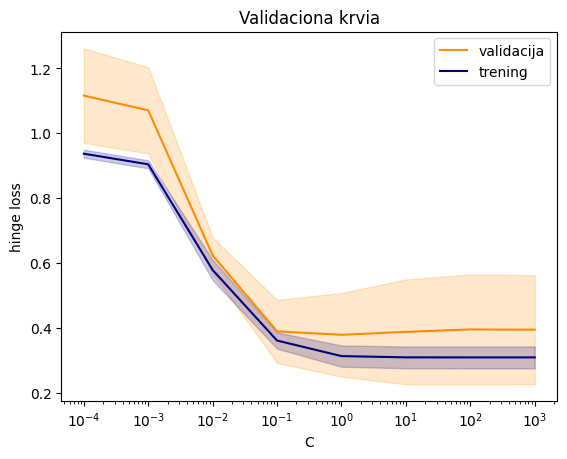

In [7]:
plt.figure()
plt.title('Validaciona krvia')
plt.xlabel('C')
plt.ylabel('hinge loss')

plt.xscale('log')

plt.plot(CC, val_scores_mean, label='validacija', color='darkorange')
plt.fill_between(CC, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='darkorange')

plt.plot(CC, train_scores_mean, label='trening', color='navy')
plt.fill_between(CC, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='navy')

plt.legend(loc='best')
plt.show()

In [8]:
C_best = CC[np.argmin(val_scores_mean)]
print(f'C = {C_best}')

svm = SVM_primal(C_best).fit(X_std, y) 

def plot_decision_boundary(clf, xmin, xmax, ymin, ymax):
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, num=100, endpoint=True),
        np.linspace(ymin, ymax, num=100, endpoint=True)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')

C = 1.0


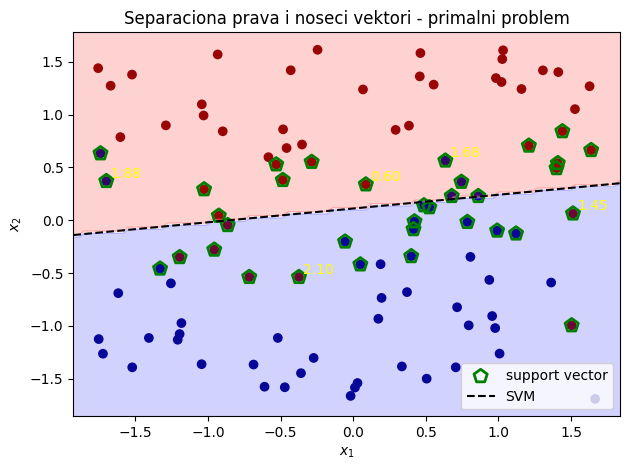

In [9]:
plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.jet)

xmin, xmax, ymin, ymax = plt.axis()
plot_decision_boundary(svm, xmin, xmax, ymin, ymax)

plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
            s=100, marker='p', facecolors='none', edgecolor='green', linewidth=2, label='support vector')

sep_line = lambda x, b, w : -(b + w[0] * x) / w[1]
xl, xr = plt.xlim()
x = np.array([xl, xr])
y_svm = sep_line(x, svm.intercept_, svm.coef_)
plt.plot(x, y_svm, '--', label='SVM', c='black')

for i in range(5):
    plt.text(svm.support_vectors_[i, 0] + 0.03, svm.support_vectors_[i, 1] + 0.03, 
             f'{svm.support_vectors_hinge_loss_[i]:.2f}', color='yellow', fontsize=10)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Separaciona prava i noseci vektori - primalni problem')
plt.tight_layout()
plt.show()

In [10]:
CC = np.array([1e-2, 1e-1, 1, 1e1, 1e2])
sigmas = np.array([0.05, 0.1, 0.5, 1, 2])
n_train = X_std.shape[0]

K = 5
train_scores = defaultdict(list)
val_scores = defaultdict(list)

for k in range(K):
    start = int(k * n_train / K)
    end = int((k + 1) * n_train / K)
    
    x_train_k = np.vstack([X_std[:start], X_std[end:]])
    y_train_k = np.hstack([y[:start], y[end:]])
    
    x_val_k = X_std[start:end]
    y_val_k = y[start:end]
    
    for i in range(len(CC)):
        C = CC[i]
        
        for j in range(len(sigmas)):
            sigma = sigmas[j]
            
            svm = SVM_dual(C, sigma).fit(x_train_k, y_train_k)
            
            train_scores[(C, sigma)].append(np.mean(np.maximum(0, 1 - y_train_k * (svm.fcn(x_train_k) + svm.intercept_))))
            val_scores[(C, sigma)].append(np.mean(np.maximum(0, 1 - y_val_k * (svm.fcn(x_val_k) + svm.intercept_))))

/Users/vuk/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'A' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(


C = 100.0, sigma = 1.0


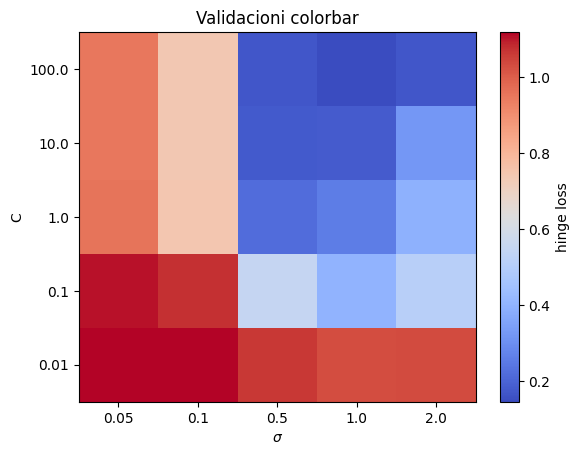

In [11]:
train_scores_mean = {k: np.mean(v) for k, v in train_scores.items()}
val_scores_mean = {k: np.mean(v) for k, v in val_scores.items()}

hinge_loss_sorted = sorted(val_scores_mean.items(), key=lambda kv: kv[1])
key_best, _ = hinge_loss_sorted[0]
C_best, sigma_best = key_best[0], key_best[1]

svm = SVM_dual(C_best, sigma_best).fit(X_std, y)
print(f'C = {C_best}, sigma = {sigma_best}')

M = np.zeros((len(CC), len(sigmas)))
for i, C in enumerate(CC):
    for j, sigma in enumerate(sigmas):
        M[i, j] = val_scores_mean[(C, sigma)]

plt.figure()
im = plt.imshow(M, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(im, label='hinge loss')

plt.xticks(range(len(sigmas)), [str(s) for s in sigmas])
plt.yticks(range(len(CC)), [str(c) for c in CC])
plt.xlabel('$\sigma$')
plt.ylabel('C')
plt.title('Validacioni colorbar')
plt.show()

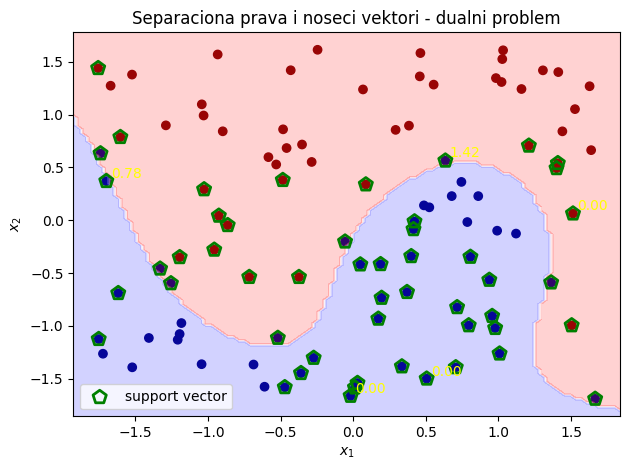

In [12]:
plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.jet)

xmin, xmax, ymin, ymax = plt.axis()
plot_decision_boundary(svm, xmin, xmax, ymin, ymax)

plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
            s=100, marker='p', facecolors='none', edgecolor='green', linewidth=2, label='support vector')

for i in range(5):
    plt.text(svm.support_vectors_[i, 0] + 0.03, svm.support_vectors_[i, 1] + 0.03, 
             f'{svm.support_vectors_hinge_loss_[i]:.2f}', color='yellow', fontsize=10)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Separaciona prava i noseci vektori - dualni problem')
plt.tight_layout()
plt.show()